<a href="https://colab.research.google.com/github/hl271/CVPR2021-02785_code/blob/main/m%E1%BA%A1ng_1_core_c%C3%B3_generate_data_cho_hardware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GIẢ LẬP KIẾN TRÚC RANC VỚI TẬP MNIST**


Tiến hành download toàn bộ code trong đường link này:
https://github.com/UA-RCL/RANC/tree/master/software
sau đó up lên colab, giải nén

Có thể sử dụng link này để download: https://minhaskamal.github.io/DownGit/#/home


In [ ]:
!unzip "software_fixed.zip"

Code này sẽ sử dụng tealayer2.0 (sử dụng tensorflow 2.x)

Sau khi giải nén, do code mặc định của họ đang sử dụng tensorflow 2.0.0b1 mà phiên bản đó giờ không còn được hỗ trợ nên cần phải chỉnh lại.

=> Truy cập "./sofware/tealayers/tealayer2.0/setup.py", chỉnh dòng 19 thành 'tensorflow-gpu==2.7.0' hoặc bất cứ phiên bản 2.x nào đang được hỗ trợ rồi lưu lại

Code của họ bị sai ở một đoạn, để sửa:

=> Đi đến "./software/tealayers/tealayer2.0/tealayer2/additivepooling.py"

Sửa dòng 73 thành "output = tf.reshape(output, [-1, int(self.num_inputs//self.num_classes), self.num_classes])" rồi lưu lại

In [ ]:
cd "./software"

[Errno 2] No such file or directory: './software'
/content/software


In [ ]:
!pip install "./tealayers/tealayer2.0"
!pip install "./rancutils"

# **CÀI ĐẶT CÁC THƯ VIỆN CẦN THIẾT**

In [ ]:
from tensorflow.image import resize as rz
from tealayer2 import Tea, AdditivePooling
from tensorflow.keras.layers import Flatten, Activation, Input, Lambda, concatenate
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# **KHỞI TẠO MẠNG**

In [ ]:
# set kích cỡ ảnh thành 16 x 16
inputs = Input(shape=(16,16,1))

# Flatten the inputs so that inputs map as: flatten_input[0] -> axon[0], ..., flatten_input[255] -> axon[255]
flattened_inputs = Flatten()(inputs)

# Generate core, đưa 256 pixel của ảnh vào core.

core0 = Lambda(lambda x : x[:, :256])(flattened_inputs)
core0 = Tea(units=250, name='tea_1')(core0)
core0 = AdditivePooling(10)(core0)

# **TRAIN MODEL**

In [ ]:
# Chuẩn bị dataset để train
(X_train, y_train), (X_test, y_test) = mnist.load_data()


# expand new axis, channel axis
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# [optional]: we may need 3 channel (instead of 1)
X_train = np.repeat(X_train, 1, axis=-1)
X_test = np.repeat(X_test, 1, axis=-1)

# it's always better to normalize
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# resize the input shape. old shape: 28, new shape: 16
X_train = rz(X_train, [16,16])
X_test = rz(X_test, [16,16])


from tensorflow.python.keras import backend
sess = backend.get_session()
X_train = sess.run(X_train)
X_test = sess.run(X_test)


# X_train = X_train.eval()
# X_test = X_test.eval()

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

predictions = Activation('softmax')(core0)

model = Model(inputs=inputs, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# X_train = X_train.reshape(-1, 16, 16, 1)
# X_test = X_test.reshape(-1, 16, 16, 1)

model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=0)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

# **TEST THỬ MODEL**

*Số lượng ảnh cần test*

In [ ]:
%cd /content/software

/content/software


In [ ]:
num_test_samples = 1

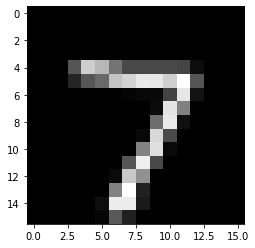

In [ ]:
X_test_temp = X_test.reshape(-1, 16, 16)
import matplotlib.pyplot as plt
for pic in range(num_test_samples):
  plt.imshow(X_test_temp[pic], cmap='gray')
  plt.show()

In [ ]:
predict = model.predict(X_test[:num_test_samples,:])
print(predict)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[8.3143692e-07 5.6021778e-09 8.3143692e-07 4.5394918e-05 3.0586855e-07
  1.6699856e-05 1.5228300e-08 9.9988961e-01 8.3143692e-07 4.5394918e-05]]


*Lưu lại output predict*

In [ ]:
predict_labels = []
for i in predict:
  predict_labels.append(np.argmax(i)) # xác suất rơi vào label nào lớn nhất
test_predictions = to_categorical(predict_labels) # lưu dưới dạng one-hot
np.save("mnist_tf_preds.txt", test_predictions)

*Nhãn dự đoán từ model*

In [ ]:
print(predict_labels)

[7]


# **GENERATE MẠNG VÀ CÁC PACKET CHO PHẦN CỨNG**

In [ ]:
%cd /content/software
# Optionally, then save the generated network out for use in the simulator and/or hardware
from rancutils.teaconversion import create_cores, create_packets, Packet
from rancutils.output_bus import OutputBus
from rancutils.serialization import save as sim_save

x_test_flat = X_test.reshape((10000, 256))
partitioned_packets = []

#test với 1 ảnh
# num_test_samples = 1
# Tạo các core bằng hàm create_cores(), sử dụng 1 layer, sử dụng 0 reset mode: neuron_reset_type=0
cores_sim = create_cores(model, 1, neuron_reset_type=0)
# Partition the packets into groups as they will be fed into each of the input cores
partitioned_packets.append(x_test_flat[:num_test_samples, :256])
# Tạo packet bằng hàm create_packets()
packets_sim = create_packets(partitioned_packets)
# Tạo output_bus bằng hàm OutputBus(coordinate, num_outputs)
output_bus_sim = OutputBus((0, 1), num_outputs=250)

# Đây chính là file đầu vào cho giả lập kiến trúc RANC bằng code C++
sim_save("input.json", cores_sim, packets_sim, output_bus_sim, indent=2)
# Lưu lại đầu ra của tensorflow predictions và correct labels để tý làm cross validation
predict = model.predict(X_test[:num_test_samples,:])
idx = []
for i in predict:
  idx.append(np.argmax(i))
test_predictions = to_categorical(idx)
np.save("tf_preds.txt", test_predictions)
np.save("correct_preds.txt", y_test[:num_test_samples,:])

/content/software


**Lưu file mem**

In [ ]:
from rancutils.emulation import output_for_testbench, output_for_streaming

In [ ]:
output_for_streaming(cores_sim,max_xy=(1,1),output_path="/content/mnist_1_core_mem")

In [ ]:
!zip -r /content/mnist_1_core_mem.zip /content/mnist_1_core_mem

  adding: content/mnist_1_core_mem/ (stored 0%)
  adding: content/mnist_1_core_mem/tc_000.mem (deflated 98%)
  adding: content/mnist_1_core_mem/csram_000.mem (deflated 87%)


In [ ]:
from google.colab import files
files.download("/content/mnist_1_core_mem.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Lưu input và output chuẩn**

In [ ]:
# lưu input và output chuẩn
output_for_testbench(packets_sim,
                         y_test[:num_test_samples,:],
                         output_path='/content/',
                         input_filename='tb_input.txt',
                         correct_filename='tb_correct.txt',
                         num_inputs_filename='tb_num_inputs.txt',
                         num_outputs_filename='tb_num_outputs.txt',
                         max_packet_xy=(512, 512),
                         num_axons=256,
                         num_ticks=16,
                         num_outputs=250)

Sau khi chạy xong đoạn code này, 3 file mới sẽ được tạo ra. Tiến hành tải file "mnist_config.json" về để làm input file cho code RANC simulator C++

# **C++**

**Compile code**

In [ ]:
cd "/content/"

/content


In [ ]:
!unzip "simulator.zip"

In [ ]:
cd "./simulator/"

/content/simulator


In [ ]:
!mkdir build

In [ ]:
cd build

/content/simulator/build


In [ ]:
!cmake ".."
!make

CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 2.8.12 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done
-- Generating done
-- Build files have been written to: /content/simulator/build
[  8%] Building CXX object CMakeFiles/ranc_sim.dir/src/core.cpp.o
[ 16%] Building CXX 

**Chạy code**

Muốn chạy với x ảnh thì số tick là x + 1, do trễ 1 tick từ 1 layer

In [ ]:
cd /content/simulator/build

/content/simulator/build


In [ ]:
!/content/simulator/build/ranc_sim -i /content/software/input.json -o /content/simulator_output.txt -c /content/simulator/config.json 10001

# **SO SÁNH ĐẦU RA TỪ SIMULATOR VỚI ĐẦU RA CỦA TENSORFLOW**

Tiến hành upload file output của simulator lên colab, chạy đoạn code này để so sánh

Lưu ý:

- Tên file đặt là "simulator_output.txt" và lưu trong đường dẫn hiện tại đang cd đến

- Trước khi upload, xóa 2 dòng đầu tiên trong file output đi (chi tiết trong file doc)

In [ ]:
    # TODO: Add usage example for outputting to emulation via rancutils.emulation.write_cores, etc.

    ###
    # ...
    # Start the simulator, etc, and collect results...
    # ...
    ###

    # Process the output to collect final classificaiton results and compare against Tensorflow predictions
    from rancutils.simulator import collect_classifications_from_simulator
    tf_output = np.load("/content/software/tf_preds.txt"+".npy")
    correct_output = np.load("/content/software/correct_preds.txt"+".npy")
    simulator_output = collect_classifications_from_simulator("/content/simulator_output.txt", num_classes=10)

    tf_output_flat = np.array([0] * tf_output.shape[0])
    for i in range(tf_output.shape[0]):
        output_i = tf_output[i, :]
        decision = np.where(output_i == max(output_i))[0]
        if len(decision) > 1:
            decision = decision[0]
        tf_output_flat[i] = decision
    tf_output = tf_output_flat

    correct_output_flat = np.array([0] * correct_output.shape[0])
    for i in range(correct_output.shape[0]):
        output_i = correct_output[i, :]
        decision = np.where(output_i == max(output_i))[0]
        if len(decision) > 1:
            decision = decision[0]
        correct_output_flat[i] = decision
    correct_output = correct_output_flat
    print(simulator_output.shape)
    if all(tf_output == simulator_output):
        print("Tensorflow output matches simulator output exactly!")
        print(f"Testing accuracy against known class labels is {(len(np.where(tf_output == correct_output[:len(tf_output)])[0]) / len(tf_output)) * 100}%")
    else:
        print("There are differences between Tensorflow and the simulator...")
        print(f"Differences are in indices {np.where(tf_output != simulator_output)}")
        print(f"Tensorflow thought the classes were {tf_output[np.where(tf_output != simulator_output)]}")
        print(f"The simulator thought the classes were {simulator_output[np.where(tf_output != simulator_output)]}")
        print(f"The correct classes were {correct_output[np.where(tf_output != simulator_output)]}")

(10000,)
Tensorflow output matches simulator output exactly!
Testing accuracy against known class labels is 91.52%
